## **Klasifikasi Audio Suara Hewan menggunakan CNN 🎙️🧠**

### **Gambaran Umum Proyek**
Proyek ini bertujuan untuk membangun model klasifikasi audio menggunakan *Convolutional Neural Network* (CNN). Model akan dilatih untuk dapat membedakan 5 jenis suara tiruan hewan yang direkam secara manual. Alur kerja proyek ini mencakup perekaman data, pra-pemrosesan audio untuk ekstraksi fitur MFCC, pembuatan arsitektur model, proses training, hingga evaluasi dan pengujian secara *real-time*.

### **Import Library dan Pengaturan Parameter Awal**
Sebelum masuk ke kode utama, kita perlu melakukan import library dan mendefinisikan beberapa parameter global. Parameter ini, seperti `SAMPLE_RATE`, `DURATION`, dan `SOUND_CLASSES`, akan digunakan secara konsisten di seluruh notebook untuk memastikan data dan model bekerja dengan benar.

In [1]:
# 1: Import library
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import librosa
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import welch

# 2: Parameters
SAMPLE_RATE = 32000
DURATION = 2  # seconds
NUM_SAMPLES = SAMPLE_RATE * DURATION
SOUND_CLASSES = ['moo', 'meow', 'woof', 'mbee', 'tweet']
DATA_DIR = './data'
os.makedirs(DATA_DIR, exist_ok=True)

## Menyiapkan Dataset untuk Training Model
Dataset yang digunakan akan didapatkan menggunakan rekaman suara anda secara langsung, yang mana anda akan diminta untuk merekam suara tiruan hewan sebanyak 15x setiap jenis suaranya.

In [2]:
# 3: Fungsi Recording untuk Merekam Data
def record_sample(sound_class, idx):
    print(f"Recording {sound_class} sample {idx + 1}/{15}...")
    recording = sd.rec(NUM_SAMPLES, samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    filename = os.path.join(DATA_DIR, f"{sound_class}_{idx}.wav")
    sf.write(filename, recording, SAMPLE_RATE)
    return filename

# 4: Rekam Data untuk Setiap Vokal
for sound_class in SOUND_CLASSES:
    os.makedirs(os.path.join(DATA_DIR, sound_class), exist_ok=True)
    # total 15 per sound class (10 train, 5 test)
    for idx in range(15):
        path = record_sample(sound_class, idx)
        os.rename(path, os.path.join(DATA_DIR, sound_class, os.path.basename(path)))

Recording moo sample 1/15...
Recording moo sample 2/15...
Recording moo sample 3/15...
Recording moo sample 4/15...
Recording moo sample 5/15...
Recording moo sample 6/15...
Recording moo sample 7/15...
Recording moo sample 8/15...
Recording moo sample 9/15...
Recording moo sample 10/15...
Recording moo sample 11/15...
Recording moo sample 12/15...
Recording moo sample 13/15...
Recording moo sample 14/15...
Recording moo sample 15/15...
Recording meow sample 1/15...
Recording meow sample 2/15...
Recording meow sample 3/15...
Recording meow sample 4/15...
Recording meow sample 5/15...
Recording meow sample 6/15...
Recording meow sample 7/15...
Recording meow sample 8/15...
Recording meow sample 9/15...
Recording meow sample 10/15...
Recording meow sample 11/15...
Recording meow sample 12/15...
Recording meow sample 13/15...
Recording meow sample 14/15...
Recording meow sample 15/15...
Recording woof sample 1/15...
Recording woof sample 2/15...
Recording woof sample 3/15...
Recording woo

## Pre-processing Dataset dan Ekstraksi Fitur 🔍
Tujuan tahap ini ialah untuk menyiapkan data mentah menjadi fitur siap model. Pre-processing meliputi proses:
- **VAD** (Voice Activity Detection) untuk membuang silent segments  
- **Padding/cropping** agar durasi konsisten  
- **Normalisasi amplitudo**  
- Ekstraksi **MFCC** (40 koefisien), distandarisasi
- Membuat Custom Dataset dan Menyimpan pasangan (MFCC, label)  
- Memisahkan dataset menjadi train (10 data) dan test (5 data)
- Definisi Arsitektur CNN

#### **Arsitektur Model CNN**
Arsitektur model CNN yang kita gunakan cukup sederhana namun efektif untuk tugas klasifikasi audio. Model ini terdiri dari:
-   **Input**: Fitur MFCC dari audio yang telah diproses.
-   **Layer Konvolusi (`Conv2d`)**: Dua lapis `Conv2d` dengan fungsi aktivasi `ReLU` bertugas untuk mengekstrak pola-pola penting dari spektogram MFCC.
-   **Layer Max Pooling (`MaxPool2d`)**: Setelah setiap layer konvolusi, `MaxPool2d` digunakan untuk mereduksi dimensi fitur (downsampling), sehingga membuat model lebih efisien dan tahan terhadap variasi posisi fitur.
-   **Layer Fully Connected (`Linear`)**: Fitur yang telah diekstrak kemudian 'diratakan' (flatten) dan dimasukkan ke dalam layer linear yang berfungsi sebagai *classifier*. Output dari layer ini adalah skor untuk masing-masing kelas suara.


In [3]:
# 5: Preprocessing Audio Preprocessing dengan VAD dan Feature Extraction
def preprocess_audio(file_path, sr=SAMPLE_RATE, num_samples=NUM_SAMPLES, top_db=20):
    y, _ = librosa.load(file_path, sr=sr)
    intervals = librosa.effects.split(y, top_db=top_db)
    if intervals.size:
        y = np.concatenate([y[start:end] for start, end in intervals])
    if len(y) < num_samples:
        y = np.pad(y, (0, num_samples - len(y)))
    else:
        y = y[:num_samples]
    max_amp = np.max(np.abs(y)) + 1e-6
    y = y / max_amp
    return y


def extract_features(file_path):
    y = preprocess_audio(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6)
    return mfcc.astype(np.float32)

# 6: Custom Dataset
def gather_files():
    all_files = []
    for label_idx, sound_class in enumerate(SOUND_CLASSES):
        files = sorted(os.listdir(os.path.join(DATA_DIR, sound_class)))
        full = [os.path.join(DATA_DIR, sound_class, f) for f in files]
        all_files += [(f, label_idx) for f in full]
    return all_files

class SoundDataset(Dataset):
    def __init__(self, file_label_pairs):
        self.data = []
        for f, label in file_label_pairs:
            feats = extract_features(f)
            self.data.append((feats[np.newaxis, ...], label))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

# 7: Menyiapkan DataLoaders
files = gather_files()
train_list, test_list = [], []
for class_idx, sound_class in enumerate(SOUND_CLASSES):
    fl = [p for p in files if p[1] == class_idx]
    train_list += fl[:10]
    test_list += fl[10:]

train_ds = SoundDataset(train_list)
test_ds = SoundDataset(test_list)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

# 8: Definisikan CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # compute output size
        dummy = torch.zeros(1,1,40, NUM_SAMPLES//512+1)
        out = self.conv(dummy)
        self.flatten_dim = out.numel()//out.shape[0]
        self.fc = nn.Linear(self.flatten_dim, len(SOUND_CLASSES))
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

### **Visualisasi Data Sampel**
Sebelum melatih model, ada baiknya kita memvisualisasikan data yang kita miliki. Visualisasi ini membantu kita untuk melihat secara kualitatif bagaimana karakteristik sinyal audio (bentuk gelombang) dan representasi fiturnya (MFCC) untuk setiap kelas suara yang berbeda. Perbedaan visual yang jelas antar kelas bisa menjadi indikasi awal bahwa data kita cukup baik untuk dilatih.

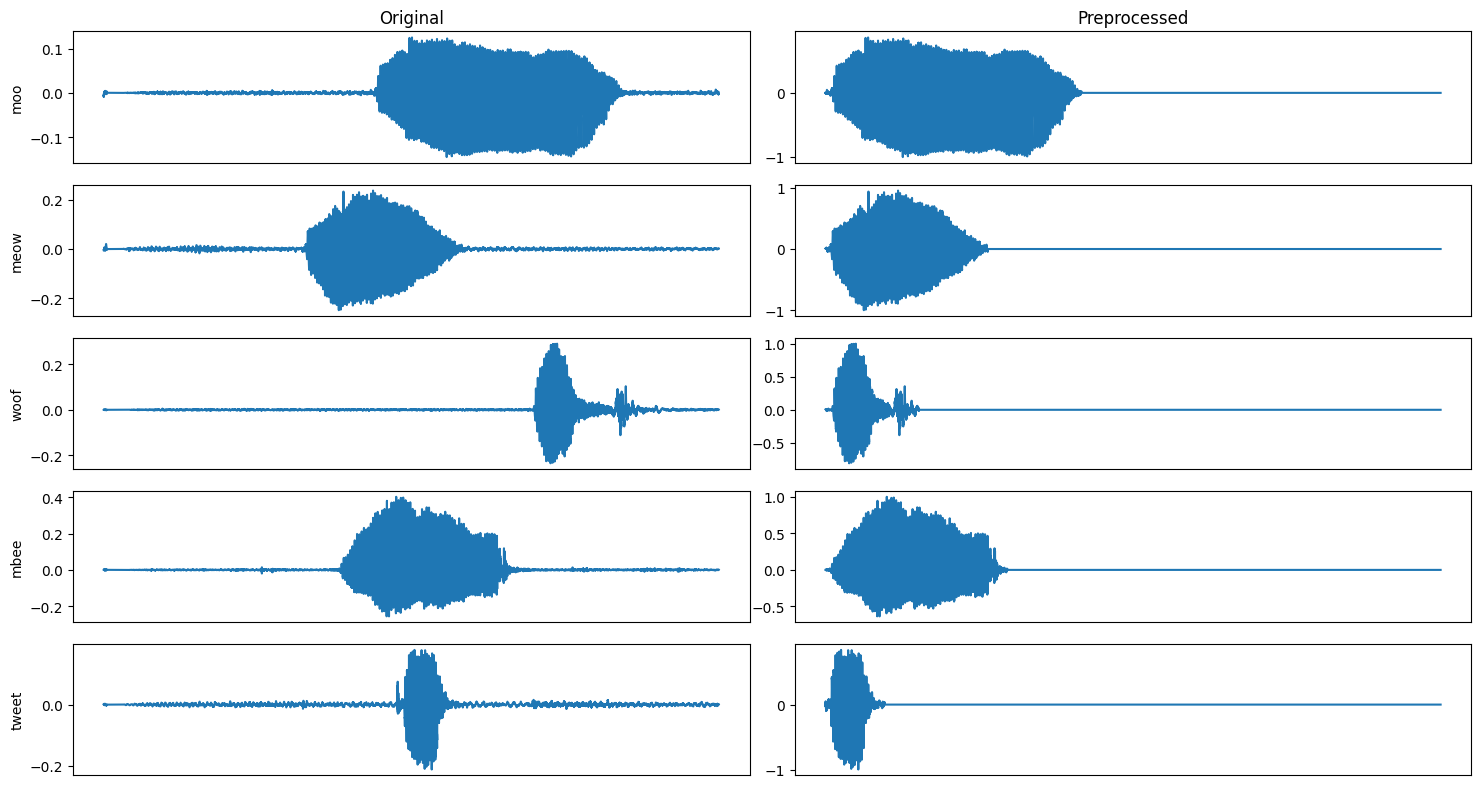

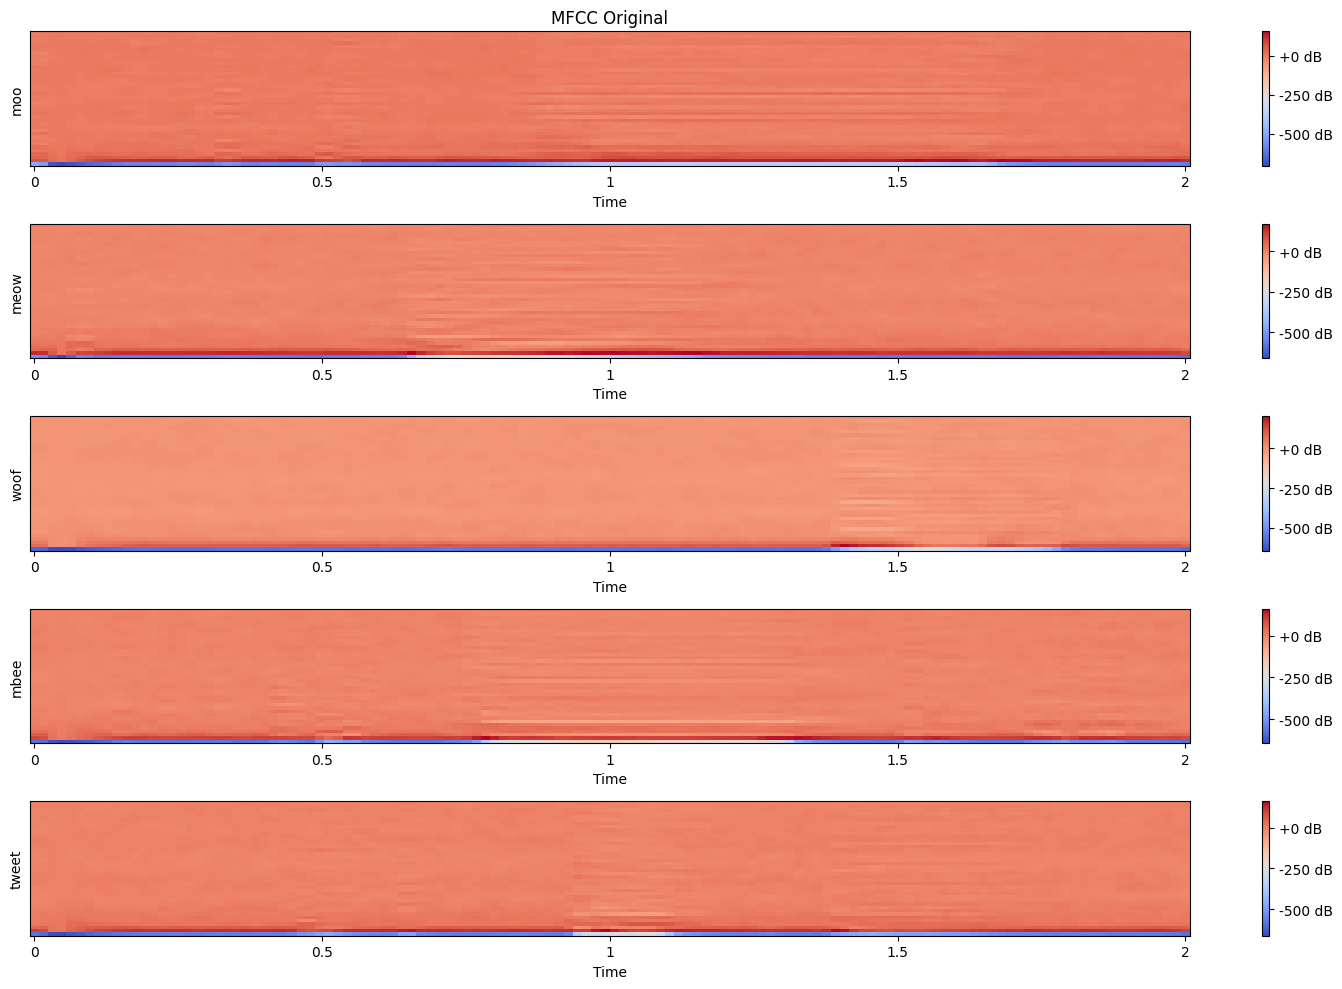

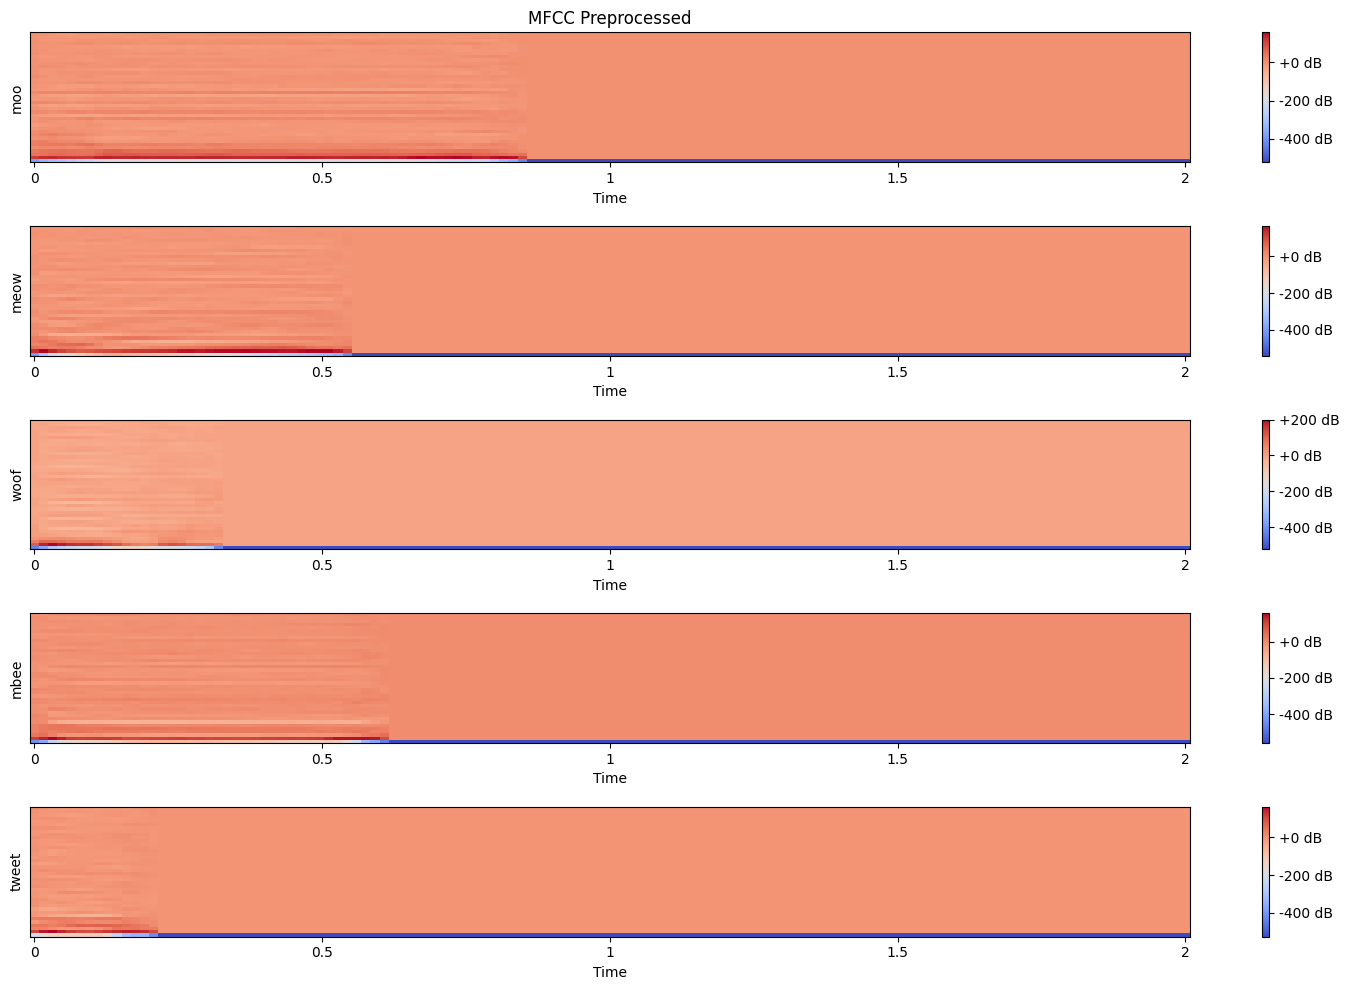

In [4]:
# Perbandingan Bentuk Gelombang dan MFCC tiap Suara
files_by_sound = {s: sorted(os.listdir(os.path.join(DATA_DIR, s))) for s in SOUND_CLASSES}
sample_idx = 0

plt.figure(figsize=(15, 8))
for i, sound in enumerate(SOUND_CLASSES):
    fpath = os.path.join(DATA_DIR, sound, files_by_sound[sound][sample_idx])
    y_o, _ = librosa.load(fpath, sr=SAMPLE_RATE)
    y_p = preprocess_audio(fpath)
    plt.subplot(len(SOUND_CLASSES), 2, 2*i+1)
    plt.plot(y_o)
    if i == 0: plt.title('Original')
    plt.ylabel(sound)
    plt.xticks([])
    plt.subplot(len(SOUND_CLASSES), 2, 2*i+2)
    plt.plot(y_p)
    if i == 0: plt.title('Preprocessed')
    plt.xticks([])
plt.tight_layout()
plt.show()


for mode, y_func in [('Original', lambda f: librosa.load(f, sr=SAMPLE_RATE)[0][:NUM_SAMPLES]),
                     ('Preprocessed', lambda f: preprocess_audio(f))]:
    plt.figure(figsize=(15, 10))
    for i, sound in enumerate(SOUND_CLASSES):
        fpath = os.path.join(DATA_DIR, sound, files_by_sound[sound][sample_idx])
        y = y_func(fpath)
        mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)
        plt.subplot(len(SOUND_CLASSES), 1, i+1)
        librosa.display.specshow(mfcc, sr=SAMPLE_RATE, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel(sound)
        if i == 0: plt.title(f'MFCC {mode}')
        else: plt.title('')
    plt.tight_layout()
    plt.show()


### Analisis Formant (Dihapus)
Bagian kode untuk menganalisis dan memvisualisasikan formant F1 dan F2 telah dihapus. Analisis formant sangat spesifik untuk studi fonetik suara vokal manusia dan tidak relevan untuk klasifikasi umum suara tiruan hewan.

### Kesimpulan Pre-Processing Data
1. Data telah dicleaning dan dinormalisasikan (terlihat dari MFCC dan gelombang suara dimana noise telah berkurang dan ukuran panjang gelombang di normalisasikan)
2. Fitur MFCC berhasil diekstrak dari setiap sampel audio, yang akan menjadi input bagi model CNN.

## **TRAINING MODEL** 📈

### **Pengaturan Proses Training**
Sekarang kita masuk ke tahap inti, yaitu melatih model. Beberapa komponen penting dalam proses training ini adalah:
-   **Device**: Memindahkan model dan data ke GPU (`cuda`) jika tersedia, untuk mempercepat proses komputasi.
-   **Loss Function**: Kita menggunakan `CrossEntropyLoss`, yang merupakan pilihan standar untuk masalah klasifikasi multi-kelas.
-   **Optimizer**: `Adam` dipilih sebagai optimizer untuk memperbarui bobot model berdasarkan *loss* yang dihitung.
-   **Epochs**: Proses training akan diulang sebanyak 100 kali (epoch) untuk memastikan model belajar dengan cukup baik dari data.

Using device: cpu
Epoch 100/100, Loss: 0.0002, Train Acc: 100.00%, Test Acc: 100.00%


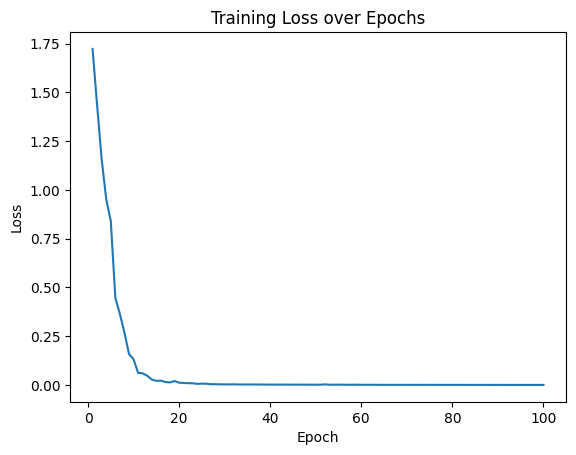

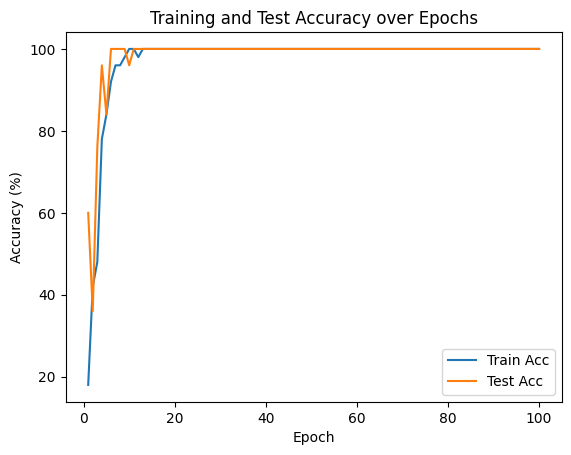

In [5]:
### 9: Training Model
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
# Initialize lists to store metrics
train_losses, train_accs, test_accs = [], [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == y).sum().item()
        total_train += y.size(0)
    avg_loss = total_loss / len(train_loader)
    train_acc = 100.0 * correct_train / total_train

    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for x_t, y_t in test_loader:
            x_t, y_t = x_t.to(device), y_t.to(device)
            out_t = model(x_t)
            preds_t = out_t.argmax(dim=1)
            correct_test += (preds_t == y_t).sum().item()
            total_test += y_t.size(0)
    test_acc = 100.0 * correct_test / total_test

    # Store metrics
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Progress
    sys.stdout.write(
        f"\rEpoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
        f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%"
    )
    sys.stdout.flush()
print()

epochs_range = range(1, epochs + 1)
# Plot loss
plt.figure()
plt.plot(epochs_range, train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Plot accuracy
plt.figure()
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()


### **Evaluasi Kinerja Model**
Setelah model selesai dilatih, kita perlu mengevaluasi kinerjanya pada data uji (*test set*) yang belum pernah dilihat sebelumnya. Kita akan melihat akurasi secara keseluruhan dan juga menggunakan `classification_report` dari `scikit-learn` untuk mendapatkan metrik yang lebih rinci seperti *precision*, *recall*, dan *f1-score* untuk setiap kelas.

In [6]:
# 10: Evaluasi Kinerja Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {correct/total*100:.2f}% \n")

# Cell 11: Classification Report
from sklearn.metrics import classification_report
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        _, pred = torch.max(out, 1)
        all_preds += pred.cpu().tolist()
        all_labels += y.tolist()
print(classification_report(all_labels, all_preds, target_names=SOUND_CLASSES))

Test Accuracy: 100.00% 

              precision    recall  f1-score   support

         moo       1.00      1.00      1.00         5
        meow       1.00      1.00      1.00         5
        woof       1.00      1.00      1.00         5
        mbee       1.00      1.00      1.00         5
       tweet       1.00      1.00      1.00         5

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



### **Menyimpan Model**
Langkah terakhir setelah evaluasi adalah menyimpan *state dictionary* (bobot) dari model yang telah dilatih. Dengan menyimpan model, kita bisa memuatnya kembali di lain waktu untuk melakukan prediksi tanpa harus mengulang proses training dari awal.

In [7]:
# Cell 12: Save Model
torch.save(model.state_dict(), 'speech_cnn.pth')
print("Model disimpan sebagai speech_cnn.pth!")

Model disimpan sebagai speech_cnn.pth!


Berdasarkan training serta evaluasi yang telah dilakukan, didapatkan model memiliki performa yang sangat baik yakni mencapai **100%** di semua evaluation metrics. Namun tentunya, mengingat dataset yang digunakan hanya sedikit, penting untuk menjadi pertimbangan pengujian kedepannya dengan menggunakan dataset yang lebih banyak dan variatif 🧮

#### **UJI COBA KLASIFIKASI SUARA DENGAN MODEL YANG TELAH DIBUAT** 🚀

In [22]:
# 13: Test Prediction via Recording dengan menampilkan confidence tiap label
import torch.nn.functional as F

def predict_from_record():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN().to(device)
    model.load_state_dict(torch.load('./speech_cnn.pth', map_location=device))

    print("Ucapkan salah satu suara hewan (moo, meow, woof, mbee, tweet)...")
    rec = sd.rec(NUM_SAMPLES, samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    temp_path = 'temp.wav'
    sf.write(temp_path, rec, SAMPLE_RATE)

    feats = extract_features(temp_path)
    x = torch.tensor(feats[np.newaxis, np.newaxis, ...]).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x)                     # raw logits
        probs = F.softmax(out, dim=1)[0]   # probability per class

    # tampilkan persentase untuk tiap suara
    for idx, sound_class in enumerate(SOUND_CLASSES):
        print(f"{sound_class}: {probs[idx].item()*100:.2f}%")

    # prediksi tertinggi
    pred_idx = probs.argmax().item()
    print(f"\nSuara Yang Diprediksi: {SOUND_CLASSES[pred_idx]}")

predict_from_record()

Ucapkan salah satu suara hewan (moo, meow, woof, mbee, tweet)...
moo: 99.94%
meow: 0.00%
woof: 0.00%
mbee: 0.06%
tweet: 0.00%

Suara Yang Diprediksi: moo
